In [1]:
!pip3 install seaborn

In [2]:
import pandas as pd
import fasttext
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from sklearn import model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

import sys
sys.path.append('/mnt/c/Users/cleon/Documents/CAL_CAL/ironhack/Final_project/Redefining_Cancer_treatment/src')
import edafunctions as edaf

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cleonortiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (10.,8.)})
sns.set_style("whitegrid")


# Exploratory Data Analysis

## 1. Reading data

In [4]:
train = pd.read_csv('../data/trainclean.csv')
test = pd.read_csv('../data/testclean.csv')

In [5]:
train.drop(columns= ['Unnamed: 0', 'Unnamed: 0.1'],inplace=True)
test.drop(columns= ['Unnamed: 0', 'Unnamed: 0.1'],inplace=True)

In [6]:
train.head()

,ID,Gene,Variation,VariationType,Effect,Class,TEXT,GeneType,Chromosome,Role,TumourType
0,0,FAM58A,Truncating Mutations,unknown,nonsense,1,cyclin dependent kinases cdks regulate variety...,Unknown,unknown,Unknown,Unknown
1,1,CBL,W802*,Substitution,nonsense,2,abstract background non small cell lung cancer...,protein-coding,11,"oncogene, TSG, fusion","AML, JMML, MDS"
2,2,CBL,Q249E,Substitution,missense,2,abstract background non small cell lung cancer...,protein-coding,11,"oncogene, TSG, fusion","AML, JMML, MDS"
3,3,CBL,N454D,Substitution,missense,3,recent evidence demonstrated acquired uniparen...,protein-coding,11,"oncogene, TSG, fusion","AML, JMML, MDS"
4,4,CBL,L399V,Substitution,missense,4,oncogenic mutations monomeric casitas b lineag...,protein-coding,11,"oncogene, TSG, fusion","AML, JMML, MDS"


In [7]:
test.head()

,ID,Gene,Variation,VariationType,Effect,TEXT,GeneType,Chromosome,Role,TumourType
0,0,ACSL4,R570S,Substitution,missense,2 mutation resulted myeloproliferative phenoty...,Unknown,unknown,Unknown,Unknown
1,1,NAGLU,P521L,Substitution,missense,abstract large tumor suppressor 1 lats1 serine...,Unknown,unknown,Unknown,Unknown
2,2,PAH,L333F,Substitution,missense,vascular endothelial growth factor receptor ve...,Unknown,unknown,Unknown,Unknown
3,3,ING1,A148D,Substitution,missense,inflammatory myofibroblastic tumor imt neoplas...,Unknown,unknown,Unknown,Unknown
4,4,TMEM216,G77A,Substitution,missense,abstract retinoblastoma pediatric retinal tumo...,Unknown,unknown,Unknown,Unknown


In [8]:
train.Role.value_counts()

TSG                      1214
oncogene                  832
oncogene, fusion          654
oncogene, TSG, fusion     292
oncogene, TSG             140
Unknown                   111
TSG, fusion                43
Oncogene                   24
fusion                     11
Name: Role, dtype: int64

## 2. Split into train test and cross validation 64:20:16

In [9]:
X = train.drop(columns='Class')
y = train.Class

In [10]:
X.shape

(3321, 10)

In [11]:
y.shape

(3321,)

In [12]:
#Spliting in train and test maintaining the proportion of each class in both datasets--> stratify = y

X_train, test_df, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [13]:
#Splitting in train and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

- train: traind_df
- test: test_df
- cv: cv_df

## 3. Univariate Analysis (UA)

Response of this model should be an array containing the 9 probabilities of being in one of the nine classes.
- alpha : used for laplace smoothing
- feature: ['gene', 'variation']
- df: ['train_df', 'test_df', 'cv_df']
- algorithm

Consider all unique values and the number of occurences of given feature in train data dataframe. Build a vector size 9, the first element = (number of times it occured in class1 + 10 * alpha / number of time it occurred in total data+90 * alpha)

gv_dict  store for every gene a (1*9) representation of it
For a value of feature in df:
- If it is in train data: --> We add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
- If it is not there in train: --> We add [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
- return 'gv_fea'

Laplace Smoothing is a technique used to asign probabilities to each feature taking into account that a new value of the feature could be in test data and not in train data. 
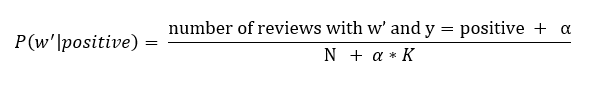
- alpha represents the smoothing parameter,
- K represents the number of dimensions (features) in the data, and
- N represents the number of reviews with y=positive

### 3.1. UA in Gene feature

In [14]:
feature_best_log_loss = {}

In [15]:
edaf.unique('Gene', train_df)

Number of Unique Gene : 234
BRCA1     163
TP53      106
BRCA2      89
EGFR       85
PTEN       75
KIT        59
BRAF       54
ALK        43
ERBB2      42
PDGFRA     38
Name: Gene, dtype: int64


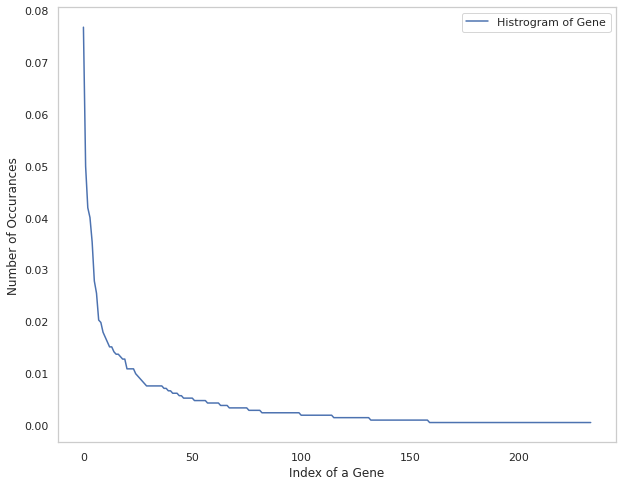

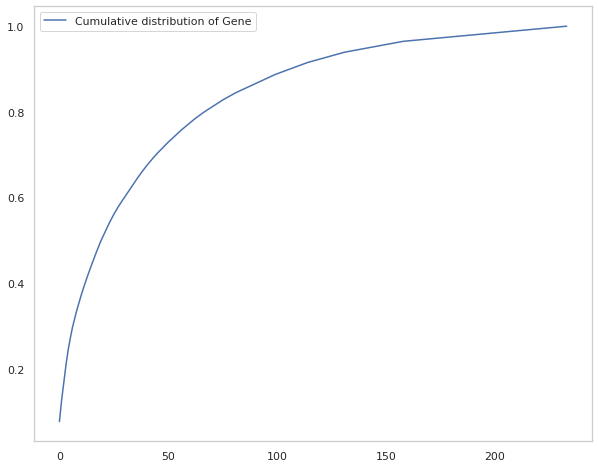

In [16]:
edaf.hist_and_cumdistr('Gene', train_df)

In [17]:
edaf.ua_sgdclassifier('Gene', train_df, test_df, cv_df, y_train, y_cv)

 The shape of Gene feature: (2124, 234)
For values of alpha: 1e-05 The log loss is: 1.1864257186077194
For values of alpha: 0.0001 The log loss is: 1.1608926033705125
For values of alpha: 0.001 The log loss is: 1.2012341048629975
For values of alpha: 0.01 The log loss is: 1.3053797894384052
For values of alpha: 0.1 The log loss is: 1.4122041363711288
For values of alpha: 1 The log loss is: 1.453880272103636


**Best alpha for Gene model is alpha= 0.0001**

In [ ]:
feature_best_log_loss['Gene']=1.1608

### 3.2. UA in Variation feature

In [19]:
edaf.unique('Variation',train_df)

Number of Unique Variation : 1926
Truncating Mutations    57
Deletion                55
Amplification           48
Fusions                 17
Overexpression           4
Q61L                     3
G13V                     2
F384L                    2
E17K                     2
S222D                    2
Name: Variation, dtype: int64


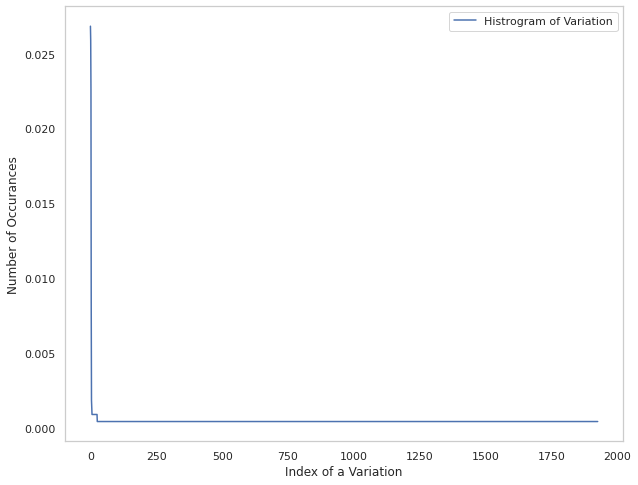

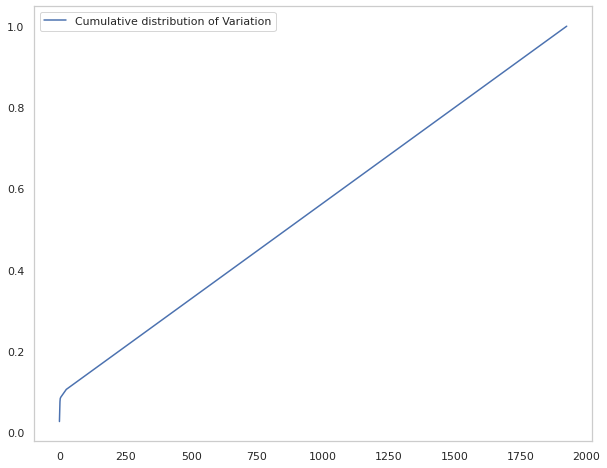

In [20]:
edaf.hist_and_cumdistr('Variation', train_df)

In [21]:
edaf.ua_sgdclassifier('Variation', train_df, test_df, cv_df, y_train, y_cv)

 The shape of Variation feature: (2124, 1956)
For values of alpha: 1e-05 The log loss is: 1.7055195256630915
For values of alpha: 0.0001 The log loss is: 1.6912321229512883
For values of alpha: 0.001 The log loss is: 1.6911184034121056
For values of alpha: 0.01 The log loss is: 1.700293177736049
For values of alpha: 0.1 The log loss is: 1.7264108268206464
For values of alpha: 1 The log loss is: 1.7269994273563367


In [ ]:
feature_best_log_loss['Variation']= 1.6911

### 3.3. UA in VariationType feature

In [23]:
edaf.unique('VariationType', train_df)

Number of Unique VariationType : 4
Substitution    1702
Deletion         236
unknown          144
Insertion         42
Name: VariationType, dtype: int64


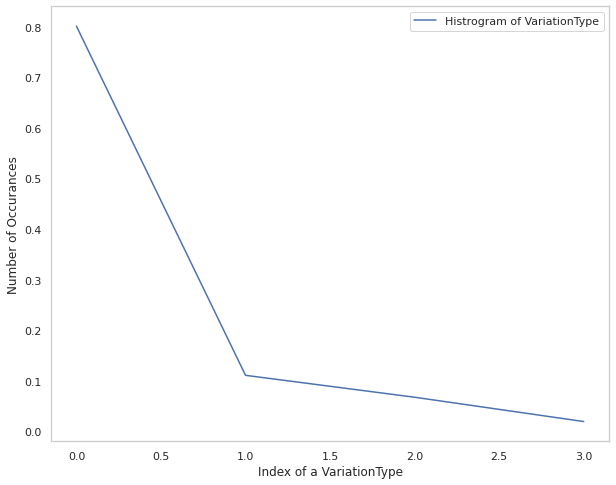

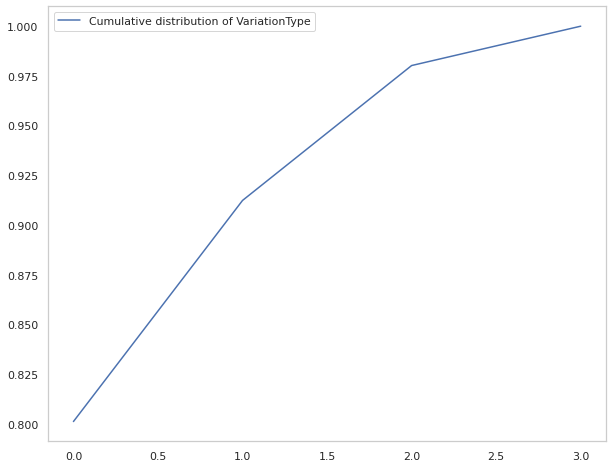

In [24]:
edaf.hist_and_cumdistr('VariationType', train_df)

In [25]:
edaf.ua_sgdclassifier('VariationType', train_df, test_df, cv_df, y_train, y_cv)

 The shape of VariationType feature: (2124, 4)
For values of alpha: 1e-05 The log loss is: 1.7660799483025236
For values of alpha: 0.0001 The log loss is: 1.7672823767416188
For values of alpha: 0.001 The log loss is: 1.7728302894335917
For values of alpha: 0.01 The log loss is: 1.7810090004786987
For values of alpha: 0.1 The log loss is: 1.782798670500812
For values of alpha: 1 The log loss is: 1.7829671596848418


In [ ]:
feature_best_log_loss['VariationType']= 1.7660

### 3.4. UA in Effect feature

In [27]:
edaf.unique('Effect', train_df)

Number of Unique Effect : 4
missense    1662
unknown      245
fusion       118
nonsense      99
Name: Effect, dtype: int64


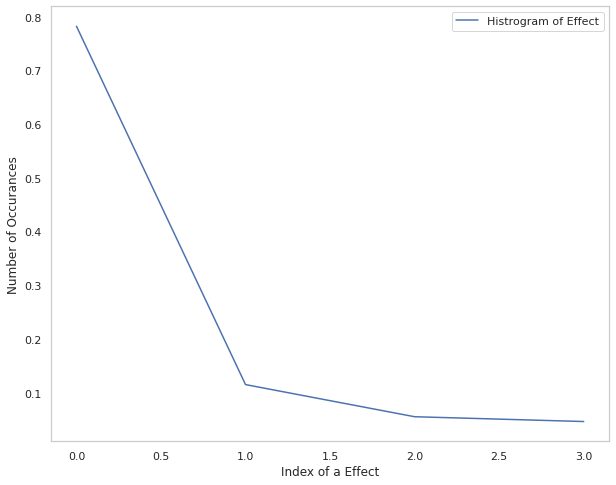

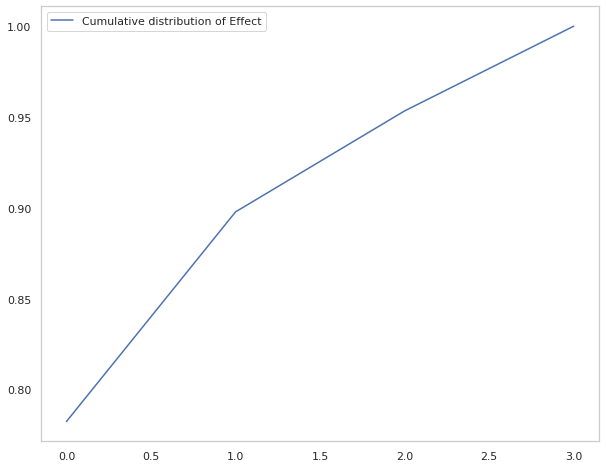

In [28]:
edaf.hist_and_cumdistr('Effect', train_df)

In [29]:
edaf.ua_sgdclassifier('Effect', train_df, test_df, cv_df, y_train, y_cv)

 The shape of Effect feature: (2124, 4)
For values of alpha: 1e-05 The log loss is: 1.7356002958971952
For values of alpha: 0.0001 The log loss is: 1.7325748943919008
For values of alpha: 0.001 The log loss is: 1.7381610907096947
For values of alpha: 0.01 The log loss is: 1.7571497904139868
For values of alpha: 0.1 The log loss is: 1.7805404270697138
For values of alpha: 1 The log loss is: 1.7845373685847306


In [ ]:
feature_best_log_loss['Effect'] = 1.7325

### 3.5. UA in GeneType feature

In [31]:
edaf.unique('GeneType', train_df)

Number of Unique GeneType : 2
Unknown           1102
protein-coding    1022
Name: GeneType, dtype: int64


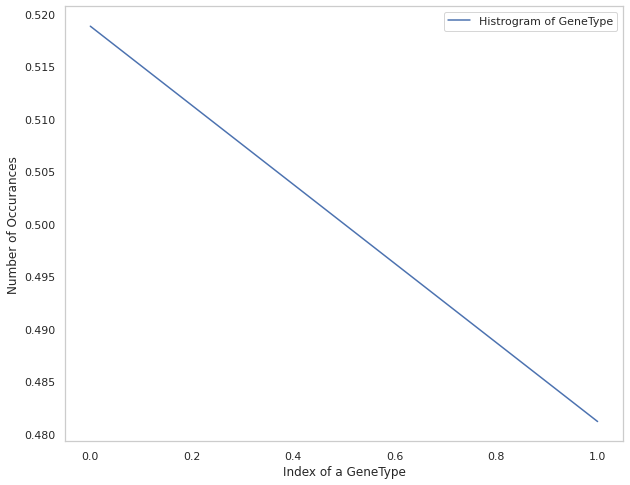

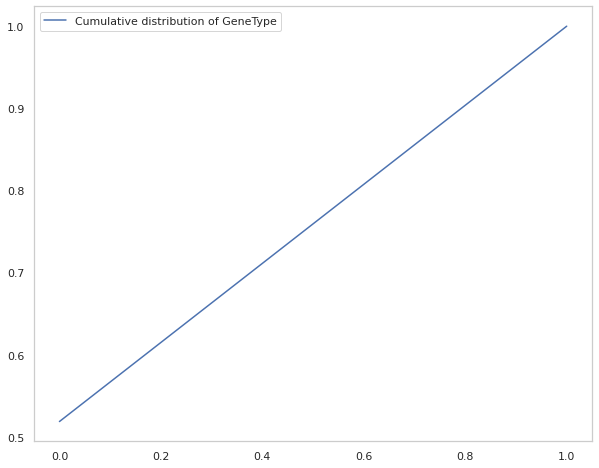

In [32]:
edaf.hist_and_cumdistr('GeneType', train_df)

In [33]:
edaf.ua_sgdclassifier('GeneType', train_df, test_df, cv_df, y_train, y_cv)

 The shape of GeneType feature: (2124, 3)
For values of alpha: 1e-05 The log loss is: 1.5905277491434866
For values of alpha: 0.0001 The log loss is: 1.5905277513897076
For values of alpha: 0.001 The log loss is: 1.5905277505514455
For values of alpha: 0.01 The log loss is: 1.5905277611912112
For values of alpha: 0.1 The log loss is: 1.5905277457410234
For values of alpha: 1 The log loss is: 1.5905277509700047


In [59]:
feature_best_log_loss['GeneType'] = 1.5905

### 3.6 UA for Role feature 

In [35]:
edaf.unique('Role', train_df)

Number of Unique Role : 9
TSG                      782
oncogene                 538
oncogene, fusion         416
oncogene, TSG, fusion    188
oncogene, TSG             79
Unknown                   70
TSG, fusion               30
Oncogene                  15
fusion                     6
Name: Role, dtype: int64


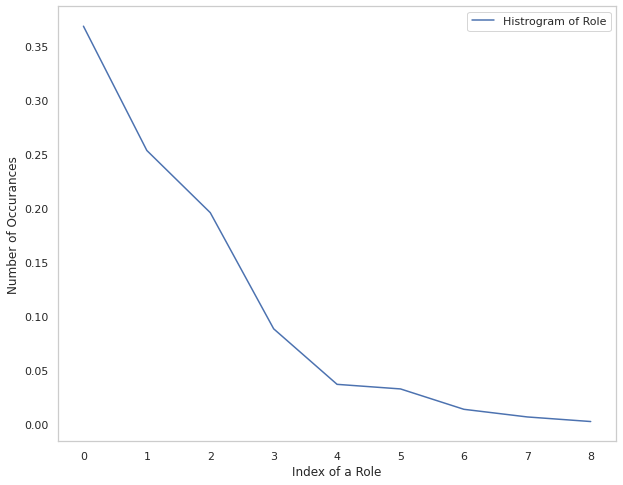

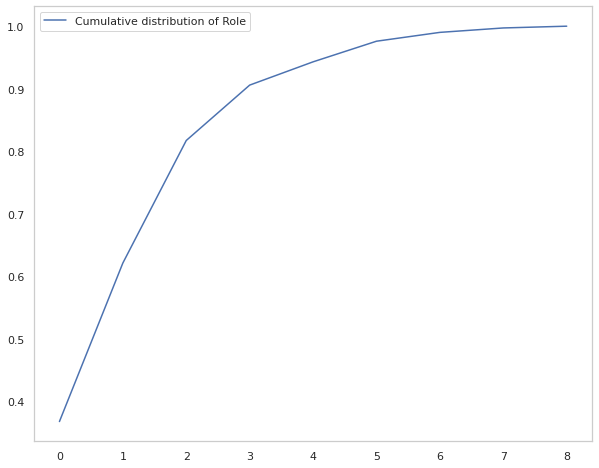

In [36]:
edaf.hist_and_cumdistr('Role', train_df)

In [37]:
edaf.ua_sgdclassifier('Role', train_df, test_df, cv_df, y_train, y_cv)

 The shape of Role feature: (2124, 4)
For values of alpha: 1e-05 The log loss is: 1.4932688438661377
For values of alpha: 0.0001 The log loss is: 1.4920652595536208
For values of alpha: 0.001 The log loss is: 1.5006862130494765
For values of alpha: 0.01 The log loss is: 1.5314710632370956
For values of alpha: 0.1 The log loss is: 1.5817286524479948
For values of alpha: 1 The log loss is: 1.6291221155347322


In [60]:
feature_best_log_loss['Role'] = 1.4920

### 3.7. UA for TumourType feature

In [39]:
edaf.unique('TumourType', train_df)

Number of Unique TumourType : 167
ovarian                                                                                                                                                                                            163
Unknown                                                                                                                                                                                            131
breast, colorectal, lung, sarcoma, adrenocortical, glioma, Spitzoid tumour, multiple other tumour types                                                                                            106
breast, ovarian, pancreatic                                                                                                                                                                         89
glioma, NSCLC                                                                                                                                                             

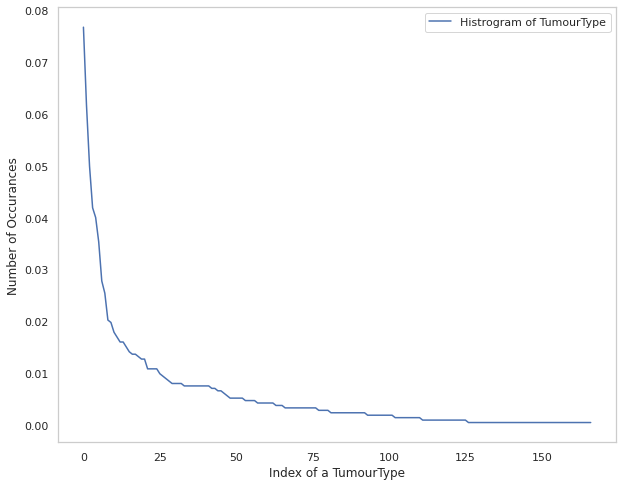

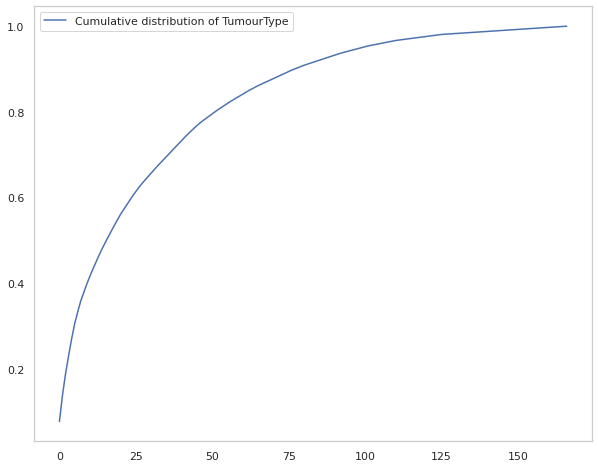

In [40]:
edaf.hist_and_cumdistr('TumourType', train_df)

In [41]:
edaf.ua_sgdclassifier('TumourType', train_df, test_df, cv_df, y_train, y_cv)

 The shape of TumourType feature: (2124, 202)
For values of alpha: 1e-05 The log loss is: 1.433420679557443
For values of alpha: 0.0001 The log loss is: 1.3275267998860243
For values of alpha: 0.001 The log loss is: 1.3506508804936435
For values of alpha: 0.01 The log loss is: 1.4263799850485408
For values of alpha: 0.1 The log loss is: 1.6023769544025543
For values of alpha: 1 The log loss is: 1.7505951624763254


In [61]:
feature_best_log_loss['TumourType'] = 1.3275

### 3.8. UA for Chromosome feature

In [43]:
edaf.unique('Chromosome', train_df)

Number of Unique Chromosome : 24
17         365
7          205
4          157
3          145
10         132
13         131
2          121
9          112
1           84
unknown     84
Name: Chromosome, dtype: int64


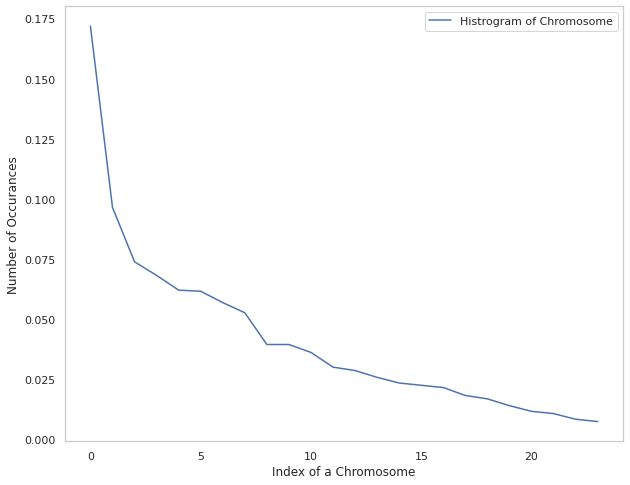

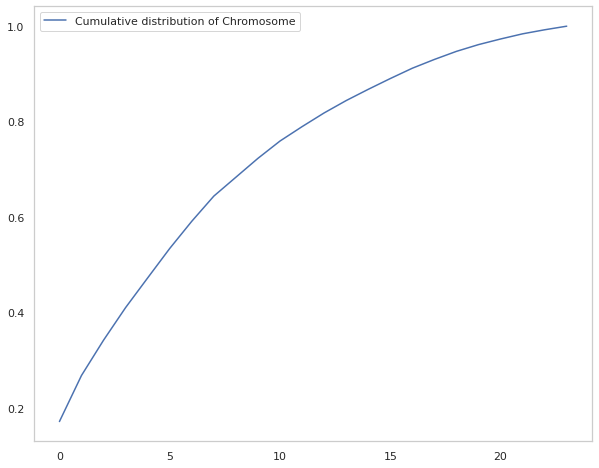

In [44]:
edaf.hist_and_cumdistr('Chromosome', train_df)

In [45]:
edaf.ua_sgdclassifier('Chromosome', train_df, test_df, cv_df, y_train, y_cv)

 The shape of Chromosome feature: (2124, 14)
For values of alpha: 1e-05 The log loss is: 1.6509138347223389
For values of alpha: 0.0001 The log loss is: 1.6327381584852387
For values of alpha: 0.001 The log loss is: 1.634453920743116
For values of alpha: 0.01 The log loss is: 1.6972413514267106
For values of alpha: 0.1 The log loss is: 1.7368830115050908
For values of alpha: 1 The log loss is: 1.7432427679061107


In [62]:
feature_best_log_loss['Chromosome'] = 1.6327

### 3.9. UA Text feature

In [47]:
def extract_dictionary_paddle(dfclasstext):
    dictionary = defaultdict(int)
    for index, row in dfclasstext.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary



In [48]:
text_vectorizer = CountVectorizer(min_df = 3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))

Total number of unique words in train data: 53420


/home/cleonortiz/anaconda3/envs/computerv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
# dict_list = [] contains 9 dictinaries each corresponding to a class
dict_list = []

for i in range(1,10):
    # Build a word dict based on the words in that class
    class_text = train_df[train['Class']==i]
    # Append it to dict_list
    dict_list.append(extract_dictionary_paddle(class_text))

/tmp/ipykernel_28368/526666236.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_text = train_df[train['Class']==i]


In [50]:
total_dict = extract_dictionary_paddle(train_df)

In [51]:
#Normalization
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [52]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))

In [53]:
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [54]:
sorted_text_occur

array([148722, 120106,  80984, ...,      3,      3,      3])

In [55]:
# Number of words for a given frequency.
words_for_freq = Counter(sorted_text_occur)

In [56]:
# Train a Logistic Regression + Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2218436495242286
For values of alpha =  0.0001 The log loss is: 1.0670189974470858
For values of alpha =  0.001 The log loss is: 1.0648481379654706
For values of alpha =  0.01 The log loss is: 1.1737961344360381
For values of alpha =  0.1 The log loss is: 1.4274932842031332
For values of alpha =  1 The log loss is: 1.634896020794157


In [63]:
feature_best_log_loss['TEXT'] = 1.0648

In [64]:
feature_errors = pd.Series(feature_best_log_loss)

In [65]:
feature_errors

Gene             1.1842
Variation        1.7168
VariationType    1.7710
Effect           1.7373
GeneType         1.5905
Role             1.4920
TumourType       1.3275
Chromosome       1.6327
TEXT             1.0648
dtype: float64

In [70]:
feature_errors.sort_values(inplace=True)

In [71]:
feature_errors.to_csv('../data/feature_errors.csv')